In [5]:
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm
import time
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2
from data import ApiFetcher
from model import TeamEmbeddings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
api = ApiFetcher(2015, 2025)
#df = api.create_numeric_with_team_ids() -- TO BE FIXED --
print(df.columns)

AttributeError: 'function' object has no attribute 'columns'

In [ ]:
def rolling_window_features(df, cols, windows=[3,5,10]):
    for team_type in ['home_team_id', 'away_team_id']:
        for window in windows:
            for col in cols:
                if col.startswith('home_') and team_type == 'home_team_id':
                    df[f'{col}_rolling_mean_{window}'] = df.groupby(team_type)[col].rolling(window).mean().reset_index(0, drop=True)
                elif col.startswith('away_') and team_type == 'away_team_id':
                    df[f'{col}_rolling_mean_{window}'] = df.groupby(team_type)[col].rolling(window).mean().reset_index(0, drop=True)
    return df

In [ ]:
statistics = ['home_fga', 'away_fga', 'home_fg_pct', 'away_fg_pct', 'home_fg3a',
       'away_fg3a', 'home_fg3_pct', 'away_fg3_pct', 'home_oreb', 'away_oreb',
       'home_dreb', 'away_dreb', 'home_ast', 'away_ast', 'home_stl',
       'away_stl', 'home_blk', 'away_blk', 'home_tov', 'away_tov', 'home_pf',
       'away_pf']
results = ['home_pts', 'away_pts']
df = rolling_window_features(df, statistics, windows=[3])
df = df.drop(columns=statistics)
df.dropna(inplace=True)


X = df.drop(columns=results)
y = df[results]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)       

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

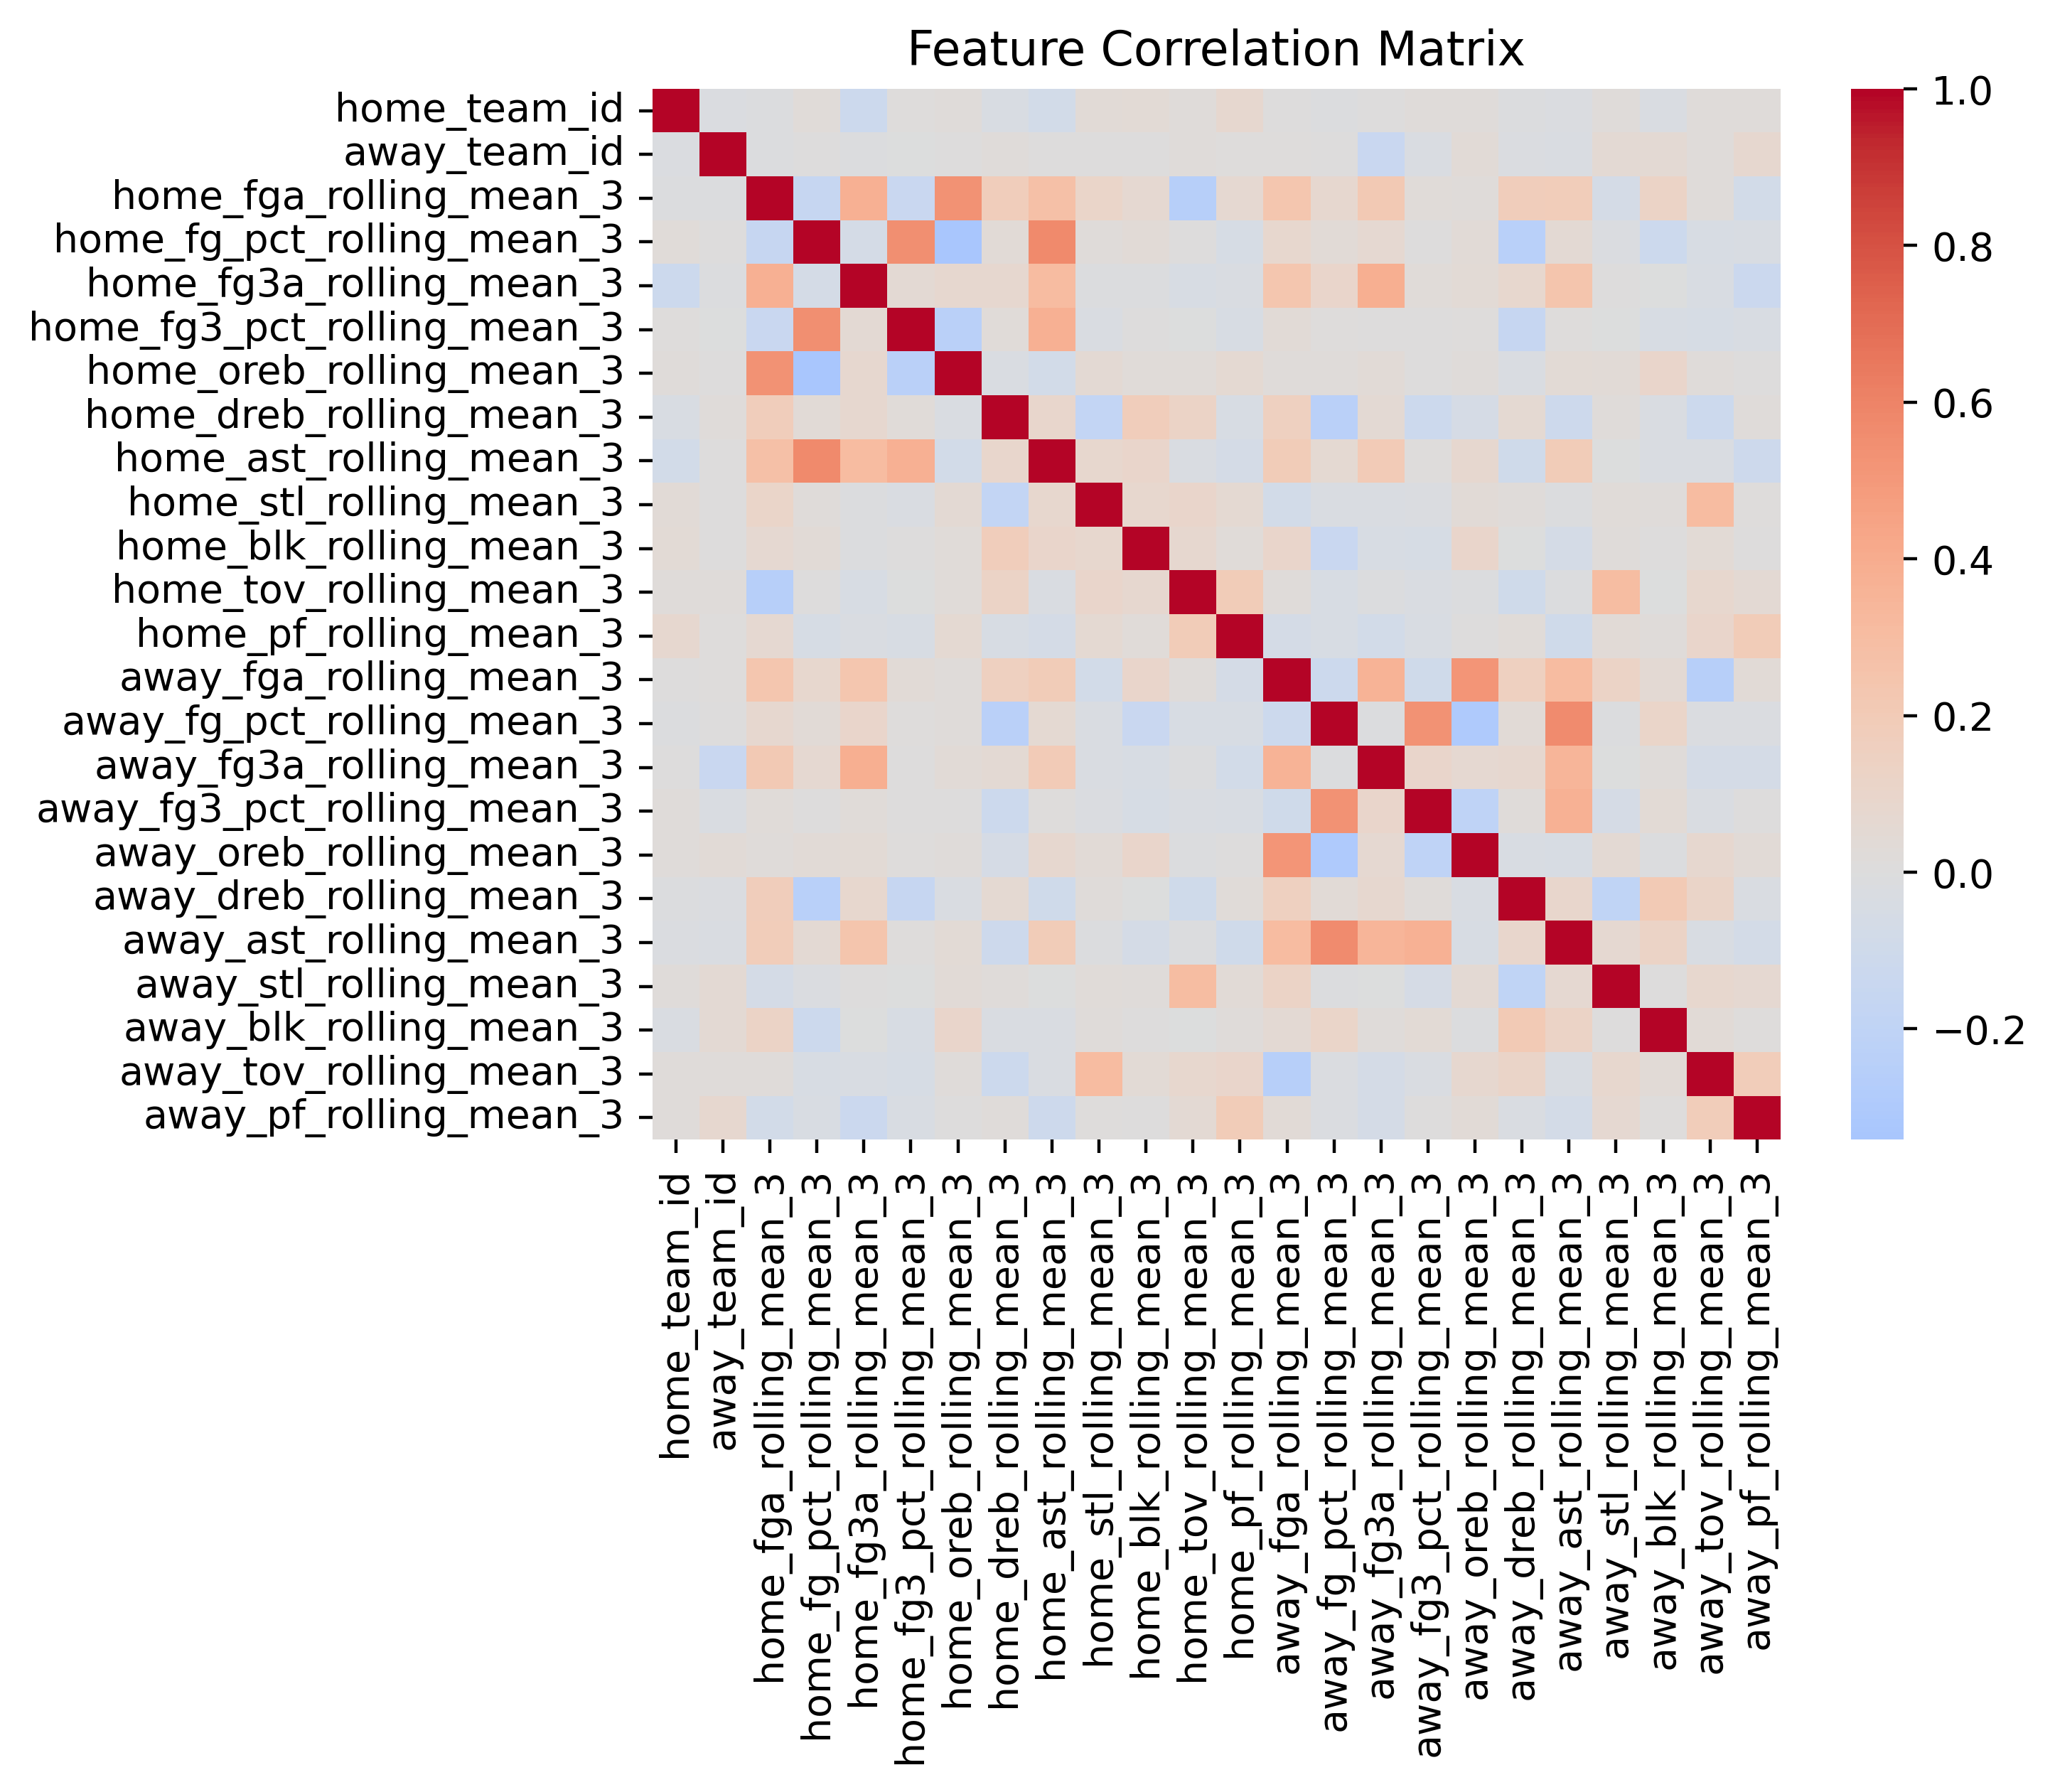

In [ ]:
plt.figure(dpi=400)
sns.heatmap(X_train_scaled.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show();

In [ ]:
# Znajdź skorelowane pary features
def find_correlated_pairs(correlation_matrix, threshold=0.8):
    """Znajdź pary features z wysoką korelacją"""
    # Usuń autokorelacje (diagonal)
    corr_no_diag = correlation_matrix.copy()
    np.fill_diagonal(corr_no_diag.values, 0)
    
    # Znajdź wysokie korelacje
    high_corr_pairs = []
    
    # Iteruj przez macierz korelacji
    for i in range(len(corr_no_diag.columns)):
        for j in range(i+1, len(corr_no_diag.columns)):  # Tylko upper triangle
            corr_value = corr_no_diag.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'feature_1': corr_no_diag.columns[i],
                    'feature_2': corr_no_diag.columns[j],
                    'correlation': corr_value
                })
    if len(high_corr_pairs) == 0:
        print(f"⚠️ No feature pairs found with correlation > {threshold}")
        return pd.DataFrame(columns=['feature_1', 'feature_2', 'correlation'])
    
    return pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)

# Znajdź skorelowane pary
correlation_matrix = X_train_scaled.corr()
corr_pairs = find_correlated_pairs(correlation_matrix, threshold=0.8)

print("🔗 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8):")
print("="*60)
for idx, row in corr_pairs.iterrows():
    print(f"{row['feature_1']:30} ↔ {row['feature_2']:30} | r = {row['correlation']:6.3f}")

print(f"\n📊 Total pairs with |correlation| > 0.8: {len(corr_pairs)}")

KeyError: 'correlation'

# Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"Model R^2: {model.score(X_test_scaled, y_test)}")
print(f"Model MSE: {np.mean((y_pred - y_test) ** 2)}")

coef_df = pd.DataFrame({
    'feature': X.columns,
    'home_pts_coef': model.coef_[0],
    'away_pts_coef': model.coef_[1],
    'abs_home_coef': np.abs(model.coef_[0]),
    'abs_away_coef': np.abs(model.coef_[1])
})

print("\nNajważniejsze cechy dla home_pts:")
print(coef_df.nlargest(5, 'abs_home_coef')[['feature', 'home_pts_coef']])

print("\nNajważniejsze cechy dla away_pts:")
print(coef_df.nlargest(5, 'abs_away_coef')[['feature', 'away_pts_coef']])

Model R^2: 0.4849443429546855
Model MSE: 85.82145952865373

Najważniejsze cechy dla home_pts:
                       feature  home_pts_coef
3   home_fg_pct_rolling_mean_3       4.748461
40    away_dreb_rolling_mean_3      -3.604619
35     away_fga_rolling_mean_3       3.312689
4     home_fg3a_rolling_mean_3       2.363626
42     away_stl_rolling_mean_3      -1.639108

Najważniejsze cechy dla away_pts:
                       feature  away_pts_coef
36  away_fg_pct_rolling_mean_3       4.492955
7     home_dreb_rolling_mean_3      -3.049784
2      home_fga_rolling_mean_3       2.975361
35     away_fga_rolling_mean_3       2.436373
37    away_fg3a_rolling_mean_3       2.161280


In [ ]:
model = Ridge()
grid_search = GridSearchCV(model, param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})
grid_search.fit(X_train_scaled, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)
print(f"Model R^2: {model.score(X_test_scaled, y_test)}")
print(f"Model MSE: {np.mean((y_pred - y_test) ** 2)}")

coef_df = pd.DataFrame({
    'feature': X.columns,
    'home_pts_coef': model.coef_[0],
    'away_pts_coef': model.coef_[1],
    'abs_home_coef': np.abs(model.coef_[0]),
    'abs_away_coef': np.abs(model.coef_[1])
})

print("\nNajważniejsze cechy dla home_pts:")
print(coef_df.nlargest(5, 'abs_home_coef')[['feature', 'home_pts_coef']])

print("\nNajważniejsze cechy dla away_pts:")
print(coef_df.nlargest(5, 'abs_away_coef')[['feature', 'away_pts_coef']])

Model R^2: 0.4848513486532238
Model MSE: 85.83709999989706

Najważniejsze cechy dla home_pts:
                       feature  home_pts_coef
3   home_fg_pct_rolling_mean_3       4.437416
40    away_dreb_rolling_mean_3      -3.407579
35     away_fga_rolling_mean_3       3.011151
4     home_fg3a_rolling_mean_3       2.057133
42     away_stl_rolling_mean_3      -1.519809

Najważniejsze cechy dla away_pts:
                       feature  away_pts_coef
36  away_fg_pct_rolling_mean_3       4.202400
7     home_dreb_rolling_mean_3      -2.903308
2      home_fga_rolling_mean_3       2.756562
35     away_fga_rolling_mean_3       2.294409
37    away_fg3a_rolling_mean_3       1.878572


In [ ]:
model = Lasso()
grid_search = GridSearchCV(model, param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})
grid_search.fit(X_train_scaled, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)
print(f"Model R^2: {model.score(X_test_scaled, y_test)}")
print(f"Model MSE: {np.mean((y_pred - y_test) ** 2)}")

coef_df = pd.DataFrame({
    'feature': X.columns,
    'home_pts_coef': model.coef_[0],
    'away_pts_coef': model.coef_[1],
    'abs_home_coef': np.abs(model.coef_[0]),
    'abs_away_coef': np.abs(model.coef_[1])
})

print("\nNajważniejsze cechy dla home_pts:")
print(coef_df.nlargest(5, 'abs_home_coef')[['feature', 'home_pts_coef']])

print("\nNajważniejsze cechy dla away_pts:")
print(coef_df.nlargest(5, 'abs_away_coef')[['feature', 'away_pts_coef']])

Model R^2: 0.48448863688623234
Model MSE: 85.89921734719888

Najważniejsze cechy dla home_pts:
                       feature  home_pts_coef
3   home_fg_pct_rolling_mean_3       4.867772
40    away_dreb_rolling_mean_3      -3.085939
35     away_fga_rolling_mean_3       3.039338
4     home_fg3a_rolling_mean_3       2.058345
2      home_fga_rolling_mean_3       1.782198

Najważniejsze cechy dla away_pts:
                       feature  away_pts_coef
36  away_fg_pct_rolling_mean_3       4.582878
2      home_fga_rolling_mean_3       3.097066
7     home_dreb_rolling_mean_3      -3.021530
35     away_fga_rolling_mean_3       2.508614
37    away_fg3a_rolling_mean_3       1.832661


# Nonlinear Regression

In [ ]:
model = RandomForestRegressor(random_state=42, bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300) # Based on grid search results
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(f"Model R^2: {model.score(X_test_scaled, y_test)}")
print(f"Model MSE: {np.mean((y_pred - y_test) ** 2)}")
try:
    importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTOP 10 najważniejszych cech:")
    print(importances_df.head(10))
except:
    print("Model jeszcze się trenuje...")


Model R^2: 0.3938523514773167
Model MSE: 100.99806436195482

TOP 10 najważniejszych cech:
                       feature  importance
36  away_fg_pct_rolling_mean_3    0.126231
3   home_fg_pct_rolling_mean_3    0.123875
35     away_fga_rolling_mean_3    0.064574
2      home_fga_rolling_mean_3    0.038686
41     away_ast_rolling_mean_3    0.023154
13     home_fga_rolling_mean_5    0.019325
4     home_fg3a_rolling_mean_3    0.018303
8      home_ast_rolling_mean_3    0.018116
40    away_dreb_rolling_mean_3    0.017763
46     away_fga_rolling_mean_5    0.016614


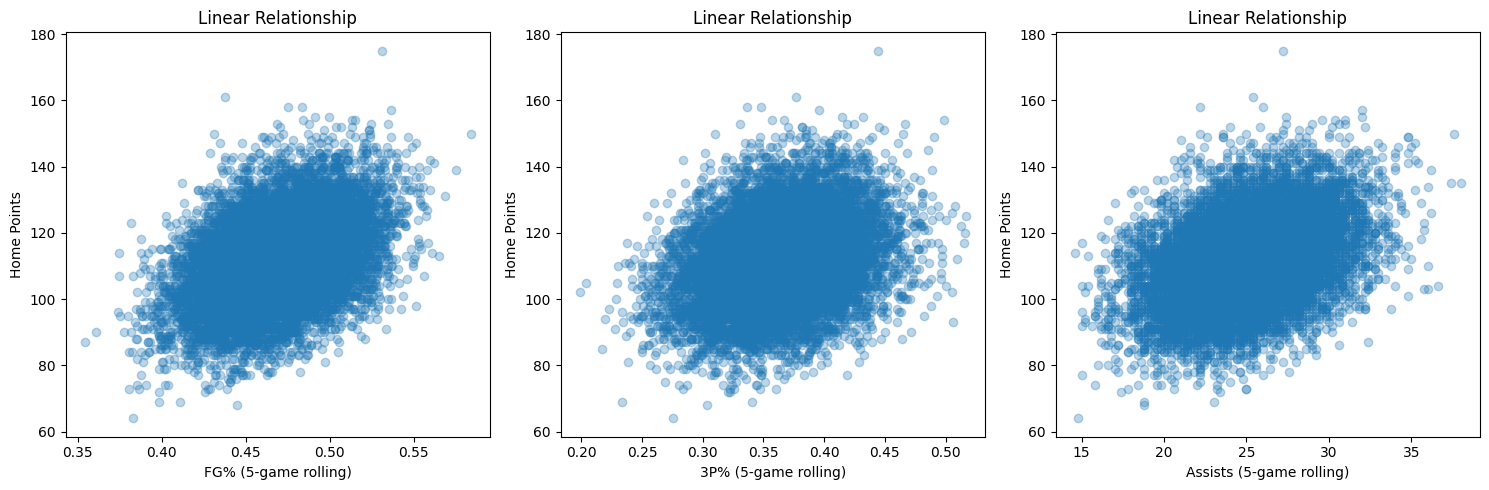

👆 Wszystkie relacje są LINIOWE! Dlatego Linear Regression wygrywa!


In [ ]:
# W NBA nie ma magicznych threshold effects:
# - Nie ma "jeśli FG% > 50% AND 3P% > 40% THEN explosive offense"
# - Wszystko jest gradual, linear relationship

# Sprawdź czy są nieliniowe relacje
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: FG% vs Points (should be linear)
plt.subplot(1, 3, 1)
plt.scatter(df['home_fg_pct_rolling_mean_5'], df['home_pts'], alpha=0.3)
plt.xlabel('FG% (5-game rolling)')
plt.ylabel('Home Points')
plt.title('Linear Relationship')

# Plot 2: 3P% vs Points (should be linear)
plt.subplot(1, 3, 2)
plt.scatter(df['home_fg3_pct_rolling_mean_5'], df['home_pts'], alpha=0.3)
plt.xlabel('3P% (5-game rolling)')
plt.ylabel('Home Points')
plt.title('Linear Relationship')

# Plot 3: Assists vs Points (should be linear)
plt.subplot(1, 3, 3)
plt.scatter(df['home_ast_rolling_mean_5'], df['home_pts'], alpha=0.3)
plt.xlabel('Assists (5-game rolling)')
plt.ylabel('Home Points')
plt.title('Linear Relationship')

plt.tight_layout()
plt.show()

print("👆 Wszystkie relacje są LINIOWE! Dlatego Linear Regression wygrywa!")

In [ ]:
# Sprawdź korelacje - prawdopodobnie bardzo wysokie
correlation_matrix = X_train_scaled.corr()
high_corr = correlation_matrix.abs() > 0.8
print("🔍 Highly correlated features:")
print(f"Number of high correlations: {high_corr.sum().sum()}")

# Rolling averages są bardzo predictable
print(f"\nRatio data/features: {X_train_scaled.shape[0] / X_train_scaled.shape[1]:.1f}")
print("= Wystarczająco dużo danych dla linear, ale za 'proste' dla tree models")

🔍 Highly correlated features:
Number of high correlations: 146

Ratio data/features: 137.4
= Wystarczająco dużo danych dla linear, ale za 'proste' dla tree models


In [ ]:
class TqdmGridSearchCV(GridSearchCV):
    def fit(self, X, y):
        # Oblicz ile będzie kombinacji
        param_combinations = 1
        for param_values in self.param_grid.values():
            param_combinations *= len(param_values)
        
        total_fits = param_combinations * self.cv
        print(f"🚀 Starting GridSearch: {param_combinations} combinations × {self.cv} CV = {total_fits} fits")
        print(f"⏱️ Estimated time: ~{total_fits * 2} seconds")
        
        # Progress bar
        self.pbar = tqdm(total=total_fits, desc="GridSearch Progress", 
                        unit="fit", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        # Hook do pokazywania postępu
        original_fit = self.estimator.fit
        def fit_with_progress(*args, **kwargs):
            result = original_fit(*args, **kwargs)
            self.pbar.update(1)
            return result
        self.estimator.fit = fit_with_progress
        
        try:
            result = super().fit(X, y)
        finally:
            self.pbar.close()
            
        print(f"✅ GridSearch completed!")
        print(f"🏆 Best score: {self.best_score_:.4f}")
        print(f"🎯 Best params: {self.best_params_}")
        
        return result

# XGBoost z progress barem
print("🔥 XGBoost GridSearch z Progress Barem!")

xgb_model = xgb.XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=0  # Wyłącz XGBoost verbose żeby nie zaśmiecać
)

# Mniejszy grid żeby nie czekać godzinami
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

print(f"📊 Combinations: {2*3*2*2} = 24 (vs RandomForest 864!)")

# GridSearch z progress barem
xgb_grid = TqdmGridSearchCV(
    xgb_model, 
    xgb_param_grid, 
    cv=3, 
    scoring='r2', 
    n_jobs=1,  # n_jobs=1 żeby progress bar działał
    verbose=0
)

# START!
start_time = time.time()
xgb_grid.fit(X_train_scaled, y_train)
end_time = time.time()

model = xgb_grid.best_estimator_

print(f"\n🎉 WYNIKI PO {(end_time - start_time)/60:.1f} minutach:")
print(f"XGBoost R^2: {model.score(X_test_scaled, y_test):.4f}")
y_pred = model.predict(X_test_scaled)
print(f"XGBoost MSE: {np.mean((y_pred - y_test) ** 2):.4f}")

# Feature importance
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏅 TOP 10 najważniejszych cech (XGBoost):")
print(importances_df.head(10))

🔥 XGBoost GridSearch z Progress Barem!
📊 Combinations: 24 = 24 (vs RandomForest 864!)
🚀 Starting GridSearch: 24 combinations × 3 CV = 72 fits
⏱️ Estimated time: ~144 seconds


GridSearch Progress:   0%|          | 0/72 [01:12<?]

✅ GridSearch completed!
🏆 Best score: 0.4602
🎯 Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

🎉 WYNIKI PO 1.2 minutach:
XGBoost R^2: 0.4540
XGBoost MSE: 90.9821

🏅 TOP 10 najważniejszych cech (XGBoost):
                        feature  importance
36   away_fg_pct_rolling_mean_3    0.090557
3    home_fg_pct_rolling_mean_3    0.085333
8       home_ast_rolling_mean_3    0.056660
41      away_ast_rolling_mean_3    0.052823
35      away_fga_rolling_mean_3    0.039017
37     away_fg3a_rolling_mean_3    0.038607
4      home_fg3a_rolling_mean_3    0.033339
2       home_fga_rolling_mean_3    0.030519
38  away_fg3_pct_rolling_mean_3    0.023604
5   home_fg3_pct_rolling_mean_3    0.022833
